In [2]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download jangedoo/utkface-new

 97% 320M/331M [00:01<00:00, 194MB/s]
100% 331M/331M [00:01<00:00, 211MB/s]


In [3]:
import os
import cv2
import numpy as np
import shutil
from os import listdir
from os.path import isdir
from PIL import Image, ImageEnhance
from numpy import asarray
from matplotlib import pyplot
import tensorflow as tf
from numpy import savez_compressed
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from keras.layers import Input
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
import random

In [4]:
! unzip utkface-new

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [5]:
utkface_path = '/content/UTKFace/'  
trial_path = '/content/Trial/'

if not os.path.exists(trial_path):
    os.mkdir(trial_path)

genders = [0, 1]
max_num_files = 25

for age in range(1, 91):
    for gender in genders:
        age_gender_files = [f for f in os.listdir(utkface_path) if f.startswith(f"{age}_{gender}_")]
        num_files = len(age_gender_files)
        if num_files < max_num_files:
            num_to_augment = max_num_files - num_files
            for i in range(num_to_augment):
                # Randomly select an existing image
                source_file = random.choice(age_gender_files)
                source_path = os.path.join(utkface_path, source_file)
                dest_file = f"{age}_{gender}_{num_files+i}.jpg"
                dest_path = os.path.join(trial_path, dest_file)
                
                # Apply image augmentation
                img = Image.open(source_path)
                enhancer = ImageEnhance.Brightness(img)
                img = enhancer.enhance(0.5)
                enhancer = ImageEnhance.Contrast(img)
                img = enhancer.enhance(0.5)
                img.save(dest_path)
                
        elif num_files >= max_num_files:
            num_files = max_num_files
            
        for i in range(num_files):
            source_file = age_gender_files[i]
            source_path = os.path.join(utkface_path, source_file)
            dest_path = os.path.join(trial_path, source_file)
            shutil.copy(source_path, dest_path)


In [6]:
len(os.listdir(trial_path))

4500

In [7]:
files = os.listdir(trial_path)
size = len(files)
print("Total samples:",size)

Total samples: 4500


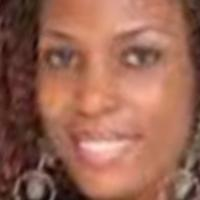

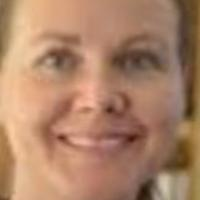

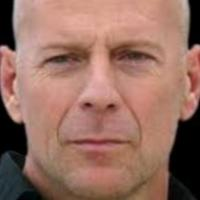

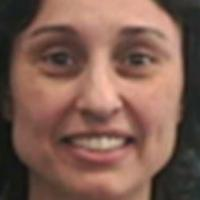

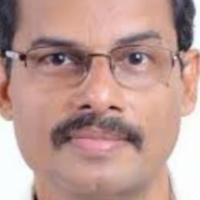

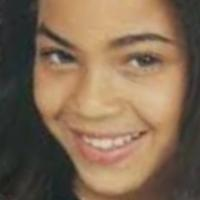

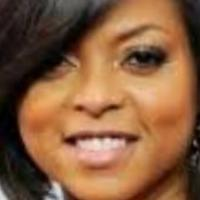

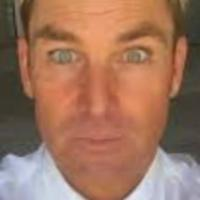

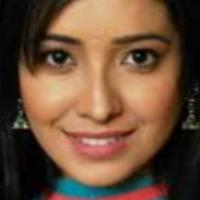

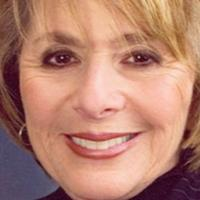

In [8]:
for i in range(10):
    image_path = os.path.join(trial_path, files[i])
    image = cv2.imread(image_path)
    cv2_imshow(image)

In [9]:
image_store = []
ages = []
genders = []
filenames = []

for filename in files:
    image = cv2.imread(trial_path + filename,1) #,0 for convert the image into gray scale
    image = cv2.resize(image,dsize=(224,224))
    image_store.append(image)
    ages.append(filename.split('_')[0])
    genders.append(int(filename.split('_')[1]))
    filenames.append(filename)

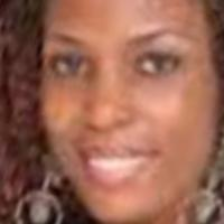

In [10]:
cv2_imshow(image_store[0])

array([[[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       ...,

       [[60, 54, 41],
        [59, 53, 40],
        [57, 51, 38],
        ...,
        [ 1,  1,  1],
        [ 0,  0,  0],
        [ 1,  1,  1]],

       [[61, 55, 42],
        [59, 53, 40],
        [57, 51, 37],
        ...,
        [ 4,  4,  4],
        [ 1,  1,  1],
        [ 0,  0,  0]],

       [[61, 55, 42],
        [59, 53, 40],
        [56, 50, 37],
        ...,
        [ 6,  6,  6],
        [ 1,  1,  1],
        [ 0,  0,  0]]], dtype=uint8)

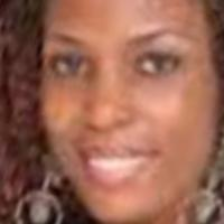

Filename: 46_1_1_20170116223430582.jpg.chip.jpg
Actual age: 46


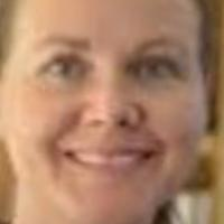

Filename: 34_1_0_20170103183211424.jpg.chip.jpg
Actual age: 34


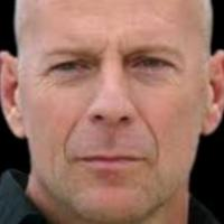

Filename: 46_0_0_20170117172149820.jpg.chip.jpg
Actual age: 46


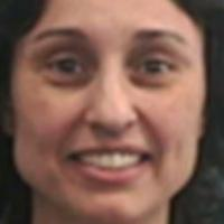

Filename: 41_1_3_20170110173815028.jpg.chip.jpg
Actual age: 41


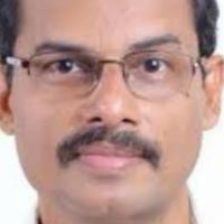

Filename: 45_0_3_20170119202002019.jpg.chip.jpg
Actual age: 45


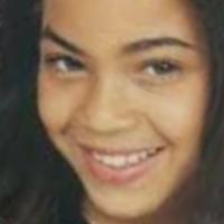

Filename: 18_1_4_20170116211941006.jpg.chip.jpg
Actual age: 18


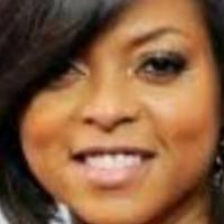

Filename: 42_1_1_20170113005712902.jpg.chip.jpg
Actual age: 42


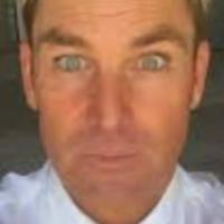

Filename: 45_0_0_20170117180911771.jpg.chip.jpg
Actual age: 45


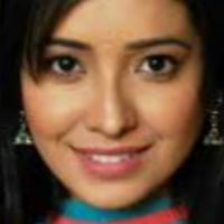

Filename: 21_1_3_20170104222105822.jpg.chip.jpg
Actual age: 21


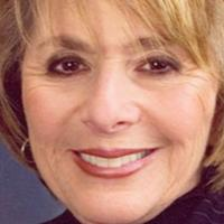

Filename: 69_1_0_20170110141304032.jpg.chip.jpg
Actual age: 69
Total samples: 4500


In [11]:
size_kitty = len(image_store)
size_genders = len(genders)
size_ages = len(ages)
idx = 2
sample = image_store[idx]
display(sample)
for i in range(10):
  cv2_imshow(image_store[i])
  name_of_files = filenames[i]
  print("Filename:", name_of_files)
  print("Actual age:", ages[i])
print("Total samples:",size_kitty)

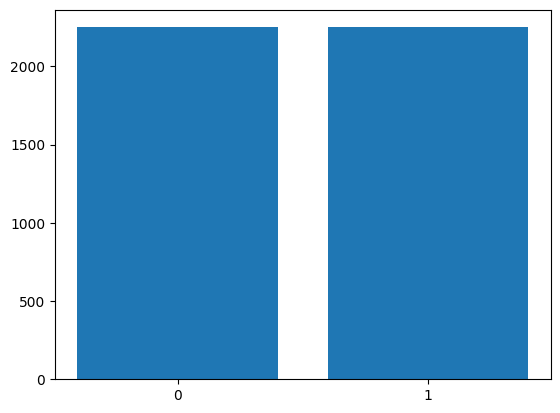

Max value: 1


In [12]:
x_genders = list(set(genders))
y_genders = [genders.count(i) for i in x_genders]

gender_labels = ['0', '1']
plt.bar(gender_labels, y_genders)

plt.show()
print("Max value:",max(genders))


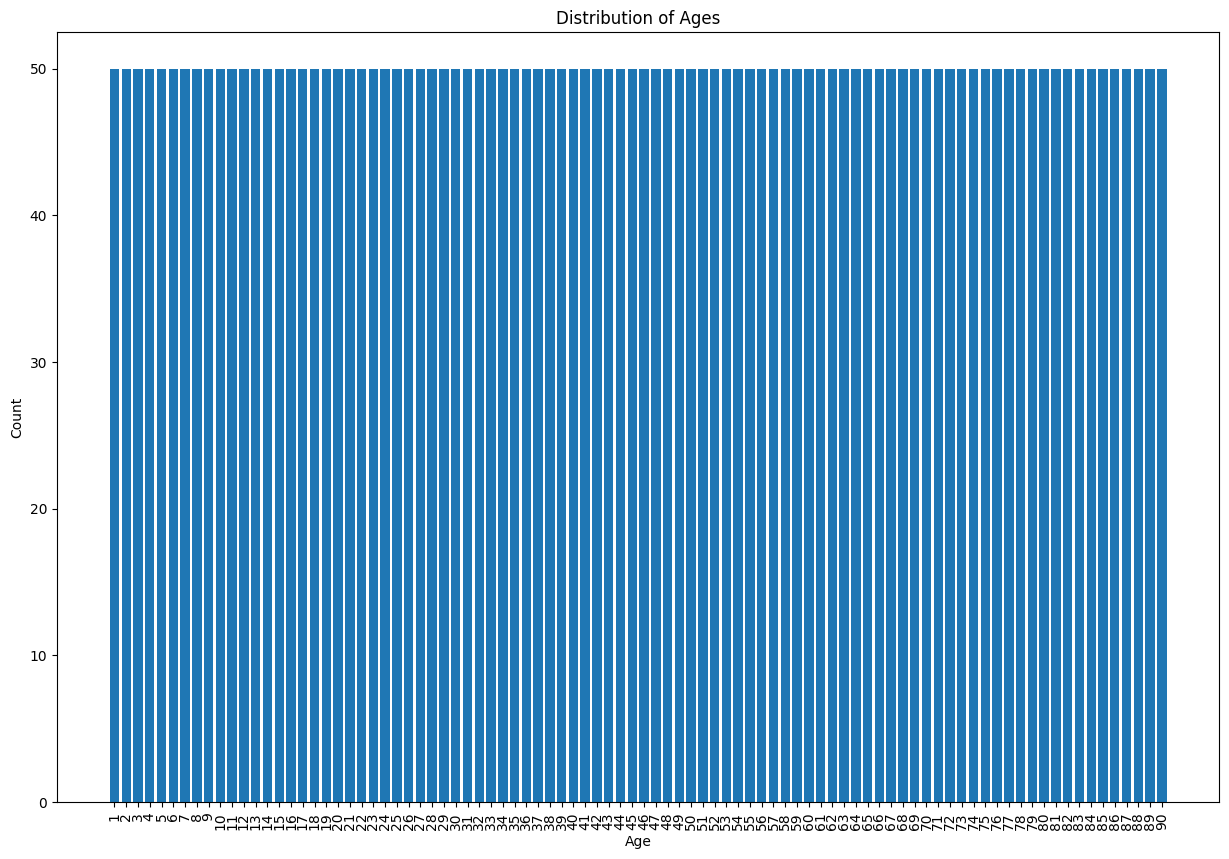

Maximum age: 90


In [13]:
# Sort the ages as integers
distribution_list = list(set(ages))
distribution_list_int = [int(s) for s in distribution_list]
distribution_list_sorted = sorted(distribution_list_int)

# Convert sorted integers back to strings with leading zeros
ages_sorted = [str(i).zfill(1) for i in distribution_list_sorted]

x_ages = list(set(ages_sorted))
x_ages = sorted(x_ages)
y_ages = [ages.count(i) for i in x_ages]

plt.figure(figsize=(15, 10)) # set size
plt.bar(ages_sorted, y_ages)

plt.xticks(rotation=90) # rotate x-axis
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Ages')

plt.show()

max_age = max(map(int, x_ages))
print("Maximum age:", max_age)


In [14]:
target = np.zeros((size_ages,1),dtype='float32')
#features = np.zeros((size_kitty,sample.shape[0],sample.shape[1]),dtype = 'float32')
features = np.zeros((size_kitty,sample.shape[0],sample.shape[1],3),dtype = 'float32')
for i in range(size_kitty):
    target[i, 0] = int(ages[i])
    features[i] = image_store[i]

In [15]:
features[0]

array([[[ 20.,  22.,  52.],
        [ 12.,  14.,  44.],
        [  8.,  10.,  40.],
        ...,
        [ 36.,  45.,  65.],
        [ 35.,  44.,  64.],
        [ 33.,  42.,  62.]],

       [[ 19.,  21.,  51.],
        [ 12.,  14.,  44.],
        [  8.,  10.,  40.],
        ...,
        [ 37.,  46.,  67.],
        [ 36.,  45.,  65.],
        [ 35.,  44.,  64.]],

       [[ 17.,  19.,  49.],
        [ 12.,  14.,  44.],
        [  8.,  10.,  40.],
        ...,
        [ 38.,  47.,  67.],
        [ 38.,  47.,  67.],
        [ 37.,  46.,  66.]],

       ...,

       [[ 31.,  42.,  71.],
        [ 29.,  40.,  69.],
        [ 27.,  38.,  67.],
        ...,
        [ 99., 102., 130.],
        [103., 107., 135.],
        [107., 110., 138.]],

       [[ 39.,  50.,  78.],
        [ 37.,  48.,  76.],
        [ 33.,  44.,  72.],
        ...,
        [101., 104., 132.],
        [103., 106., 134.],
        [104., 107., 135.]],

       [[ 46.,  57.,  85.],
        [ 43.,  54.,  82.],
        [ 38.,  

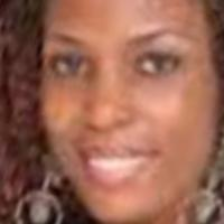

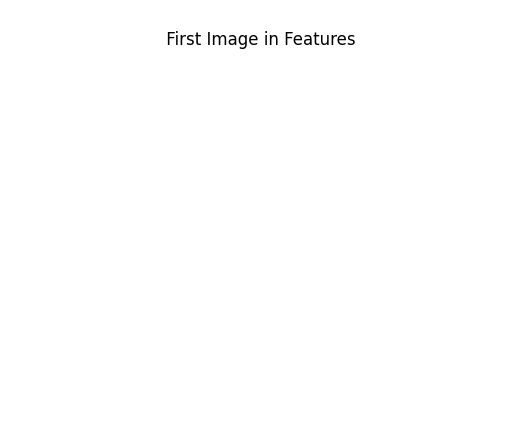

In [16]:
# Rescale each pixel [0,255]
features_first_img = np.clip(features[0], 0, 255)

cv2_imshow(features_first_img)
plt.axis('off')

plt.title("\n First Image in Features")

plt.show()


In [17]:
features = features / 255 #normalization
features[0]

array([[[0.07843138, 0.08627451, 0.20392157],
        [0.04705882, 0.05490196, 0.17254902],
        [0.03137255, 0.03921569, 0.15686275],
        ...,
        [0.14117648, 0.1764706 , 0.25490198],
        [0.13725491, 0.17254902, 0.2509804 ],
        [0.12941177, 0.16470589, 0.24313726]],

       [[0.07450981, 0.08235294, 0.2       ],
        [0.04705882, 0.05490196, 0.17254902],
        [0.03137255, 0.03921569, 0.15686275],
        ...,
        [0.14509805, 0.18039216, 0.2627451 ],
        [0.14117648, 0.1764706 , 0.25490198],
        [0.13725491, 0.17254902, 0.2509804 ]],

       [[0.06666667, 0.07450981, 0.19215687],
        [0.04705882, 0.05490196, 0.17254902],
        [0.03137255, 0.03921569, 0.15686275],
        ...,
        [0.14901961, 0.18431373, 0.2627451 ],
        [0.14901961, 0.18431373, 0.2627451 ],
        [0.14509805, 0.18039216, 0.25882354]],

       ...,

       [[0.12156863, 0.16470589, 0.2784314 ],
        [0.11372549, 0.15686275, 0.27058825],
        [0.10588235, 0

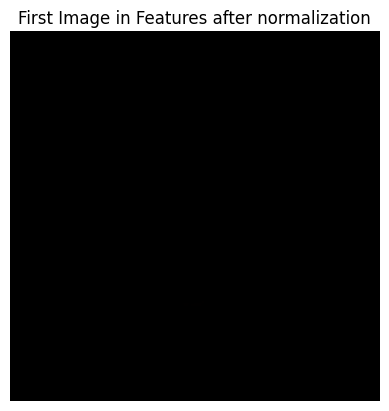

In [18]:
features_first_img_after_normalization = np.clip(features[0], 0, 255)/255
plt.imshow(features_first_img_after_normalization[:, :, ::-1], vmin=0, vmax=1)
plt.axis('off')

plt.title("First Image in Features after normalization")

plt.show()


In [19]:
x_train, x_test, y_train, y_test, filenames_train, filenames_test = train_test_split(features, target, filenames, test_size=0.2,shuffle  = True)
# make the age that will be trained are in the value of 0-1
y_train

array([[65.],
       [52.],
       [44.],
       ...,
       [41.],
       [13.],
       [ 3.]], dtype=float32)

In [20]:
print('number of x_train: ', len(x_train))
print('number of y_train: ', len(y_train))
print('number of x_test: ', len(x_test))
print('number of y_test: ', len(y_test))
print('x_train type:', type(x_train))
print('y_train type:', type(y_train))
print('x_test type:', type(x_test))
print('y_test type:', type(y_test))

number of x_train:  3600
number of y_train:  3600
number of x_test:  900
number of y_test:  900
x_train type: <class 'numpy.ndarray'>
y_train type: <class 'numpy.ndarray'>
x_test type: <class 'numpy.ndarray'>
y_test type: <class 'numpy.ndarray'>


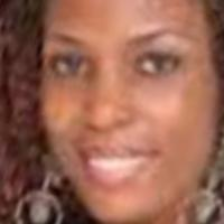

Filename: 46_1_1_20170116223430582.jpg.chip.jpg
Actual age: 46


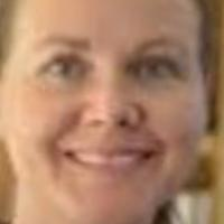

Filename: 34_1_0_20170103183211424.jpg.chip.jpg
Actual age: 34


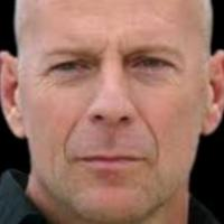

Filename: 46_0_0_20170117172149820.jpg.chip.jpg
Actual age: 46


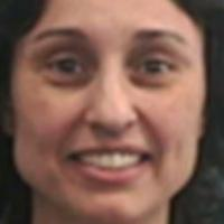

Filename: 41_1_3_20170110173815028.jpg.chip.jpg
Actual age: 41


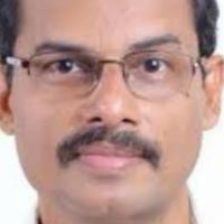

Filename: 45_0_3_20170119202002019.jpg.chip.jpg
Actual age: 45


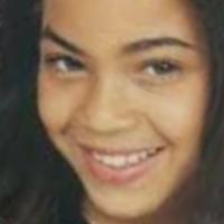

Filename: 18_1_4_20170116211941006.jpg.chip.jpg
Actual age: 18


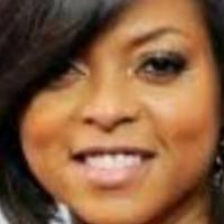

Filename: 42_1_1_20170113005712902.jpg.chip.jpg
Actual age: 42


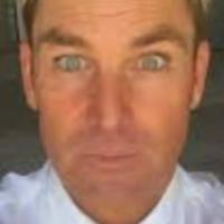

Filename: 45_0_0_20170117180911771.jpg.chip.jpg
Actual age: 45


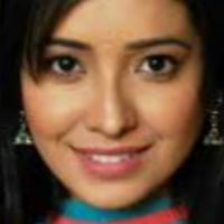

Filename: 21_1_3_20170104222105822.jpg.chip.jpg
Actual age: 21


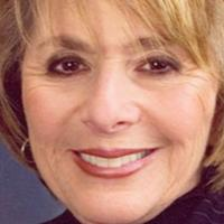

Filename: 69_1_0_20170110141304032.jpg.chip.jpg
Actual age: 69
Total samples: 4500


In [21]:
for i in range(10):
  filenumber = image_store[i]
  cv2_imshow(filenumber)
  name_of_files = filenames[i]
  print("Filename:", name_of_files)
  print("Actual age:", ages[i])
print("Total samples:",size_kitty)

In [22]:
print(x_train.shape)
print(y_train.shape)

(3600, 224, 224, 3)
(3600, 1)


In [23]:
input_shape = (224, 224, 3)
inputs = tf.keras.layers.Input(shape=input_shape)


x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = Dropout(0.5)(x)


x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)

my_model = Model(inputs=inputs, outputs=outputs)

my_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])



In [24]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=2) ]

history1 = my_model.fit(x_train, y_train,
                    batch_size = 10,
                    epochs=30,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks)

Epoch 1/30
360/360 [==============================] - 30s 49ms/step - loss: 785.1509 - mae: 23.5522 - val_loss: 736.7817 - val_mae: 23.1834 - lr: 0.0010
Epoch 2/30
360/360 [==============================] - 16s 43ms/step - loss: 567.2543 - mae: 19.8507 - val_loss: 538.4598 - val_mae: 18.8644 - lr: 0.0010
Epoch 3/30
360/360 [==============================] - 16s 43ms/step - loss: 411.7879 - mae: 16.3494 - val_loss: 437.2934 - val_mae: 17.3573 - lr: 0.0010
Epoch 4/30
360/360 [==============================] - 16s 43ms/step - loss: 370.9497 - mae: 15.3943 - val_loss: 411.0408 - val_mae: 16.7749 - lr: 0.0010
Epoch 5/30
360/360 [==============================] - 16s 43ms/step - loss: 337.1470 - mae: 14.7402 - val_loss: 448.9335 - val_mae: 17.1327 - lr: 0.0010
Epoch 6/30
360/360 [==============================] - 16s 43ms/step - loss: 305.9698 - mae: 14.0020 - val_loss: 393.0670 - val_mae: 15.9746 - lr: 0.0010
Epoch 7/30
360/360 [==============================] - 16s 43ms/step - loss: 307.71

In [25]:
y_pred = my_model.predict(x_test)
for u in range(len(y_pred)):
  y_pred[u] = int(y_pred[u])

29/29 [==============================] - 1s 24ms/step


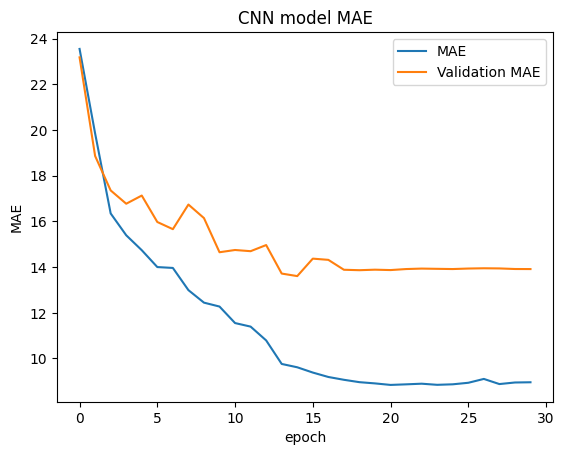

In [26]:
plt.plot(history1.history['mae'])
plt.plot(history1.history['val_mae'])
plt.title('CNN model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(["MAE","Validation MAE"])
plt.show()

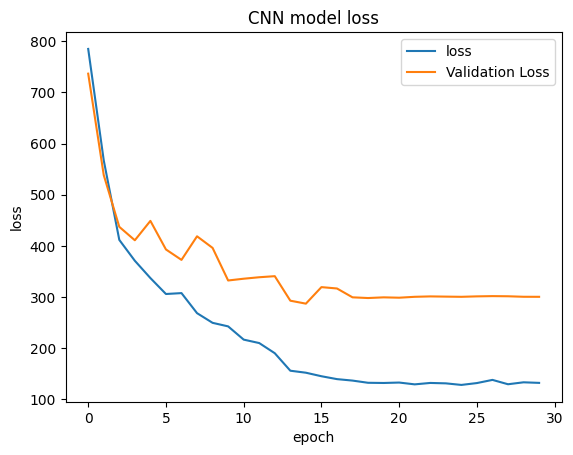

In [27]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["loss","Validation Loss"])
plt.show()

In [28]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("CNN RMSE: ", rmse)

CNN RMSE:  17.53799


In [29]:
def error_count(error):
  error1 = 0
  error2 = 0
  error3 = 0
  error4 = 0
  if error <= 5:
    error1 = error1+1
  elif error <= 10:
    error2 = error2+1
  elif error <= 15:
    error3 = error3+1
  elif error > 15:
    error4 = error4+1
  return error1,error2,error3,error4

In [35]:
predicted_age_list = []
y_test_list = []
error1_total = 0
error2_total = 0
error3_total = 0
error4_total = 0

for i in range(400):
    image = x_test[i]
    name_of_files = filenames_test[i]
    predicted_age = my_model.predict(np.expand_dims(x_test[i], axis=0))
    predicted_age = int(predicted_age)
    predicted_age_list.append(predicted_age)
    percent_dif =  (abs(predicted_age-int(y_test[i]))/ int(max_age)) * 100
    print("percent difference: ", int(percent_dif), "%")
    error_count(percent_dif)
    error1, error2, error3, error4 = error_count(percent_dif)
    error1_total += error1
    error2_total += error2
    error3_total += error3
    error4_total += error4

print("Number of error less than 5%:", error1_total)
print("Number of error less than 10%:", error2_total)
print("Number of error equal or less than 15%:", error3_total)
print("Number of error more than 15%:", error4_total)

1/1 [==============================] - 0s 33ms/step
percent difference:  8 %
1/1 [==============================] - 0s 40ms/step
percent difference:  12 %
1/1 [==============================] - 0s 39ms/step
percent difference:  12 %
1/1 [==============================] - 0s 24ms/step
percent difference:  17 %
1/1 [==============================] - 0s 37ms/step
percent difference:  36 %
1/1 [==============================] - 0s 49ms/step
percent difference:  23 %
1/1 [==============================] - 0s 34ms/step
percent difference:  12 %
1/1 [==============================] - 0s 40ms/step
percent difference:  11 %
1/1 [==============================] - 0s 30ms/step
percent difference:  15 %
1/1 [==============================] - 0s 32ms/step
percent difference:  12 %
1/1 [==============================] - 0s 29ms/step
percent difference:  6 %
1/1 [==============================] - 0s 31ms/step
percent difference:  0 %
1/1 [==============================] - 0s 28ms/step
percent differe

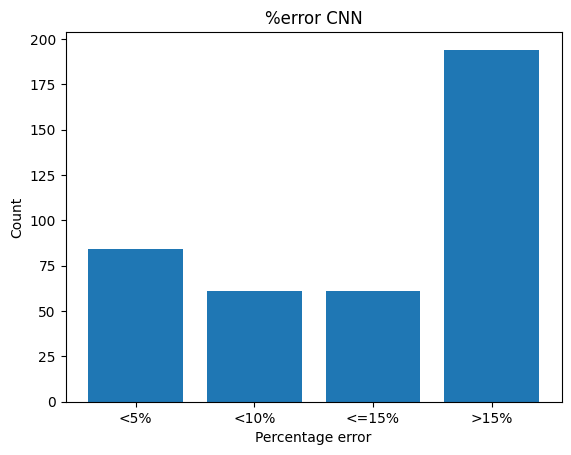

In [37]:

values = [error1_total, error2_total, error3_total, error4_total]
labels = ['<5%', '<10%', '<=15%', '>15%']

# Plot the bar graph
plt.bar(labels, values)

# Add labels to the graph
plt.title('%error CNN')
plt.xlabel('Percentage error')
plt.ylabel('Count')

# Display the graph
plt.show()


In [38]:
predicted_age_list = []
y_test_list = []
error1_total = 0
error2_total = 0
error3_total = 0
error4_total = 0

for i in range(50):
    fig, ax = plt.subplots()
    image = x_test[i]
    name_of_files = filenames_test[i]
    ax.tick_params(axis='both', which='major', labelsize=0)
    plt.imshow(image[:, :, ::-1])
    plt.show()
    print("Filename:", name_of_files)
    print("Actual age:", int(y_test[i]))
    predicted_age = my_model.predict(np.expand_dims(x_test[i], axis=0))
    predicted_age = int(predicted_age)
    predicted_age_list.append(predicted_age)
    print("Real | Predict")
    print(int(y_test[i]), "  |" , predicted_age)
    percent_dif =  (abs(predicted_age-int(y_test[i]))/ int(max_age)) * 100
    print("percent difference: ", int(percent_dif), "%")
    error_count(percent_dif)
    error1, error2, error3, error4 = error_count(percent_dif)
    error1_total += error1
    error2_total += error2
    error3_total += error3
    error4_total += error4

Output hidden; open in https://colab.research.google.com to view.

In [39]:
print("Number of error less than 5%:", error1_total)
print("Number of error less than 10%:", error2_total)
print("Number of error equal or less than 15%:", error3_total)
print("Number of error more than 15%:", error4_total)

Number of error less than 5%: 12
Number of error less than 10%: 12
Number of error equal or less than 15%: 7
Number of error more than 15%: 19


In [33]:
my_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 111, 111, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                         

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 KB 15.1 MB/s eta 0:00:00


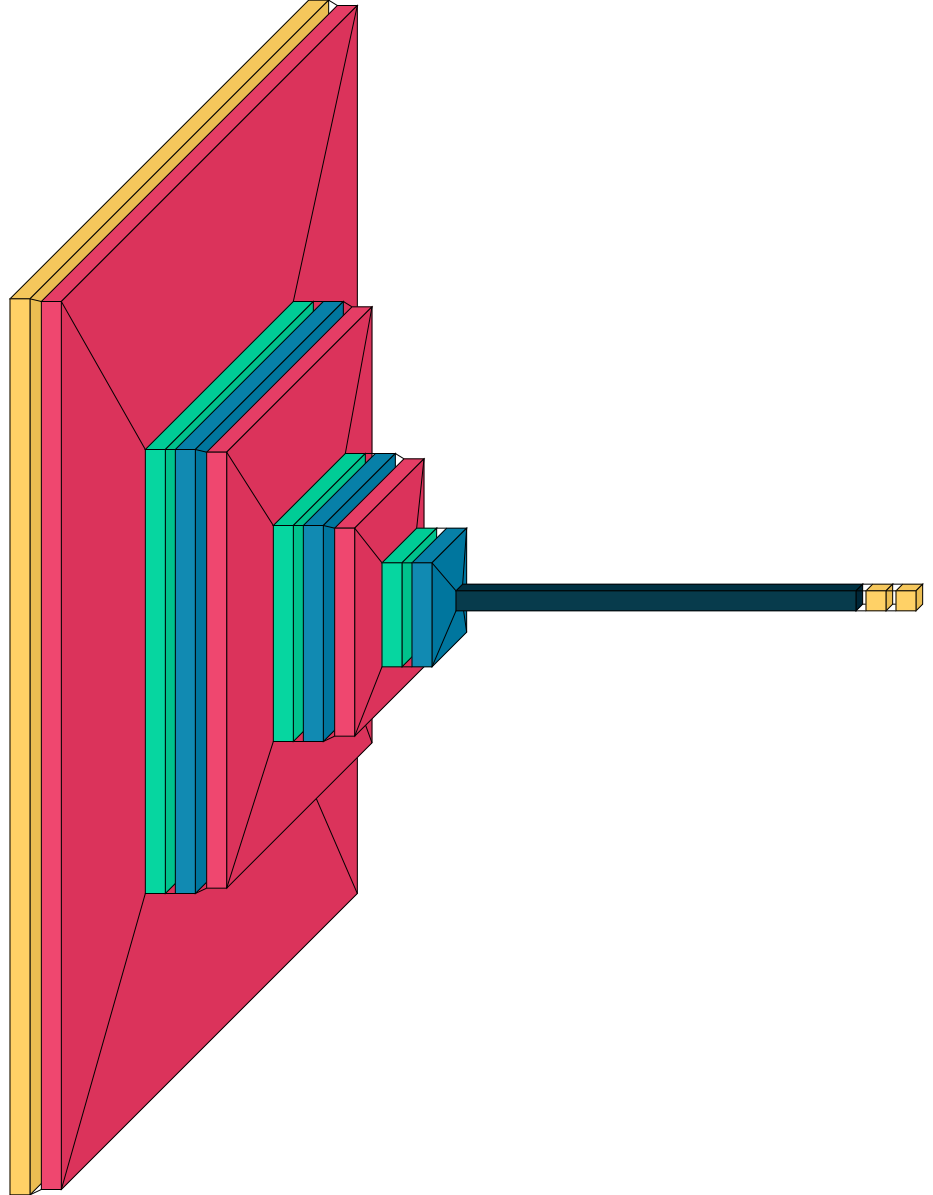

In [34]:
!pip install visualkeras  
import visualkeras
visualkeras.layered_view(my_model)